## No More Clickbait!: Clickbait Detection for Indonesian News Headlines

Dataset used in this project can be downloaded from this link : [Click-ID Dataset](https://data.mendeley.com/datasets/k42j7x2kpn/1)

Click-ID Dataset is composed of news headline dataset collected fron twelve local online news publishers in Indonesia; detikNews, Fimela, Kapanlagi, Kompas, Liputan6, Okezone, Posmetro-Medan, Republika, Sindonews, Tempo, Tribunnews, and Wowkeren. This dataset consist of two parts; (i) raw article data, and (ii) annotated news headlines as either clickbait or non-clickbait. Annotation was done by 3 judges examining only the news headlines.


The main goal of this project is to build classification model to detect clickbaits and deploys in a web app. It could then be developed as a filter for local online news to prevent clickbaits to be uploaded.

### 1. Combine Raw and Annotated Datasets

In [1]:
import pandas as pd
import os

# Local Online News Publishers
publishers = ['detikNews','fimela','kapanlagi','kompas','liputan6','okezone',
           'pos_metro','republika','sindonews','tempo','tribunnews','wowkeren']

# Root Directory
rdir = os.path.dirname(os.getcwd())

# Append Raw Data from All Publishers
raw_df = []
for publisher in publishers:
    raw_file_path = rdir + '\\data\\raw\\csv\\' + publisher + '.csv'
    raw_df.append(pd.read_csv(raw_file_path))
raw_df = pd.concat(raw_df)

# Get Annotated Data Where All Three Judges Agreed
ann_file_path = rdir + '\\data\\annotated\\combined\\csv\\all_agree.csv'
annotated_df = pd.read_csv(ann_file_path)

# Merge Raw and Annotated Data on Title
full_df = pd.merge(annotated_df,raw_df,on='title',how='inner')
full_df.drop_duplicates(subset='title',keep='first',inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8489 entries, 0 to 8888
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         8489 non-null   object
 1   label         8489 non-null   object
 2   label_score   8489 non-null   int64 
 3   source        8489 non-null   object
 4   date          8489 non-null   object
 5   time          8489 non-null   object
 6   category      8489 non-null   object
 7   sub-category  8489 non-null   object
 8   content       8460 non-null   object
 9   url           8489 non-null   object
dtypes: int64(1), object(9)
memory usage: 729.5+ KB


There are 8.489 entries in the resulting datasets. This number is lower than 15.000 available annotated datasets mentioned before. It is because only titles which receives unanimous decision from the annotators were picked for further analysis. It is done to improve the quality of data, and thus, the accuracy of models.

### 2. Cleaning Data

In [2]:
# Adjust Date Format
from datetime import *

month_name = {'Januari':'January','Februari':'February','Maret':'March','Mei':'May','Juni':'June',
            'Juli':'July','Agustus':'August','Oktober':'October','Nopember':'November','Desember':'December'}

def format_date(dt):
    text = datetime.strftime(dt,'%Y-%m-%d')
    return text

for month in month_name:
    full_df['date'] = full_df['date'].str.replace(month,month_name[month])
full_df['date'] = pd.to_datetime(full_df['date']).apply(format_date)

# Adjust Time Format
full_df['time'] = full_df['time'].str.replace(' WIB','')
full_df['time'] = full_df['time'].str.replace('-','NA')

In [3]:
# Group Categories
category_name = {
    'News':['Dunia','Kilas Kementerian','DPD RI', 'DPR RI', 'Australia Plus','Metropolitan','detikNews','News','Global',
            'Regional','nasional','Berita Utama','Berita Sumut','Medan Bung', 'Kriminal','Internasional','Medan Update',
            'Mpr Ri','Daerah', 'Metro','International','metro','dunia'],
    'Celebrity & Entertainment':['Musik','Selebriti', 'Film', 'TV','Seleb','News & Entertainment','SELEBRITI', 'KOREA',
                                 'FILM INTERNASIONAL','FILM INDONESIA', 'SINETRON', 'HOLLYWOOD', 'TELEVISI','Entertainment',
                                 'ShowBiz','Celebrity','Dahlan Iskan','seleb'],
    'Sports':['Sport','Super Skor','Bola','Sepak Bola','sport','bola'],
    'Business & Economy':['Bea Cukai','Pertamina','Money','Properti','Bisnis','Economy','Ekonomi','Beacukai',
                         'Ekbis', 'bisnis'],
    'Lifestyle':['Kalbe Health Corner','Parenting', 'Lifestyle','Beauty','Travel','Health','Kesehatan','pariwisata','Leisure',
                'cantik','travel', 'gaya'],
    'Science & Technology':['Tekno','Sains','Techno','Teknologi','Pendidikan','tekno'],
    'Otomotive':['Otomotif','Oto Tek','otomotif','Autotekno'],
    'Religion & Culture':['Kuliner','Haji','Muslim','Ihram','Khazanah'],
    'Others':['SerbaSerbi','Tribunners','Berita Viral','Kisah Nyata','Acit Nai', 'Ragam', 'Humor Medan','hiburan',
             'creativelab','event', 'difabel','Kolom', 'Retizen','Konsultasi','Sastra', 'English','fokus']
}

def main_category(string,main):
    for key in main:
        if string in main[key]:
            string = key
    return string

full_df['category'] = full_df['category'].apply(lambda x: main_category(x,category_name))

### 3. Eksplorasi Data Clickbait di Indonesia

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

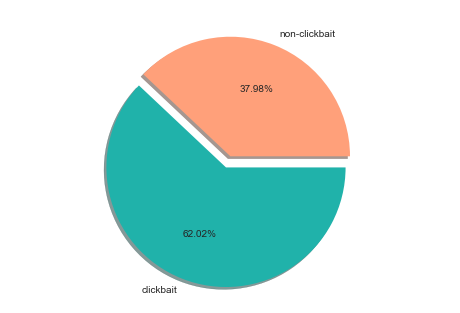

In [5]:
# 1. Clickbait and Non-Clickbait Titles Composition
fig, ax = plt.subplots()
ax.axis('equal')
ax.pie(
    x = full_df.groupby('label')['title'].count(),
    labels = full_df['label'].unique(),
    autopct = '%1.2f%%',
    colors = ['LightSalmon','LightSeaGreen'],
    explode = (0, 0.1), shadow = True
)
plt.show()

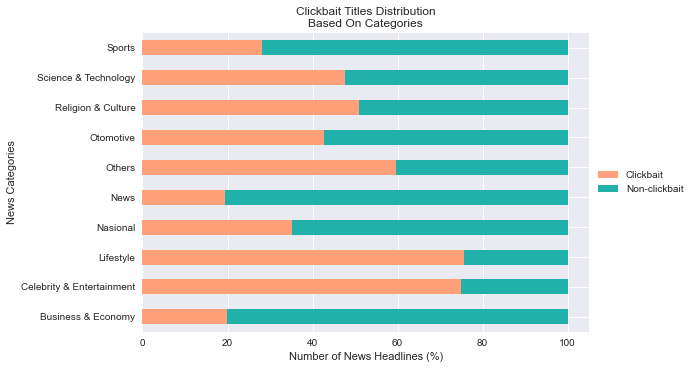

In [6]:
# 2. Clickbait Distribution Based On Categories
category_df = full_df.groupby(['category','label'])['title'].count()
category_df = category_df.groupby(level=0).apply(lambda x: round(x * 100 / x.sum(),2))
category_df = category_df.reset_index().pivot(index='category',columns='label')

category_df.plot(kind='barh',color = ['LightSalmon','LightSeaGreen'],stacked=True)
plt.title('Clickbait Titles Distribution\nBased On Categories')
plt.ylabel('News Categories')
plt.xlabel('Number of News Headlines (%)')
plt.legend(['Clickbait', 'Non-clickbait'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Unsurprisingly, clickbait titles are often found on entertainment and lifestyle news rather than on more serious news.<br>
It is also notable that news in Others category also relatively have more clickbaits.

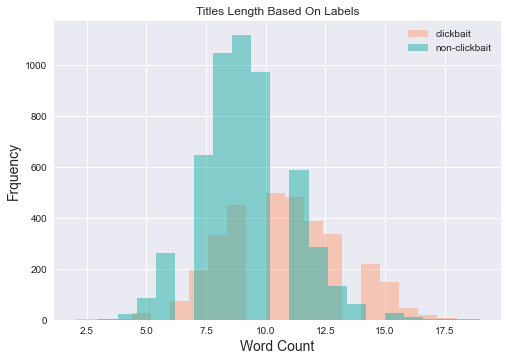

In [7]:
# 4. Titles Length Based On Labels
def word_count(string):
    return len(string.split(' '))

full_df['length'] = full_df['title'].apply(word_count)
clickbait_length = full_df[full_df['label'] == 'clickbait']['length']
non_clickbait_length = full_df[full_df['label'] == 'non-clickbait']['length']

plt.hist(clickbait_length, bins=20, alpha=0.5, label="clickbait", color = 'LightSalmon')
plt.hist(non_clickbait_length, bins=20, alpha=0.5, label="non-clickbait", color = 'LightSeaGreen')

plt.xlabel("Word Count", size=14)
plt.ylabel("Frquency", size=14)
plt.title("Titles Length Based On Labels")
plt.legend(loc='upper right')

Clickbait titles often uses shorter but catchy titles while non-clickbait titles usually have longer titles to explain better the news it represents

### 4. Preprocessing Headline Berita di Indonesia

In [8]:
import string, re
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Add More Stopwords
stop = ['rp','bj','aku','radar','habibie','indonesia','jokowi','polisi','anak']

# Customized Preprocessing Functions
def preprocess_title(titles,more_stop=stop):

    # 1. Lowercase and Remove Punctuation
    lowercase_titles = titles.lower()
    no_pun = re.sub(r'[>)}:{",?+!\[\].(<;1234567890]','',lowercase_titles)
    no_pun = re.sub('\n','',no_pun)
    
    # 2. Remove Stopwords
    stopwords = StopWordRemoverFactory().get_stop_words() + more_stop
    data_stop = ArrayDictionary(stopwords)
    srf = StopWordRemover(data_stop)
    passed = srf.remove(no_pun)

    # 3. Stemming Process
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed = stemmer.stem(passed)
        
    return stemmed

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

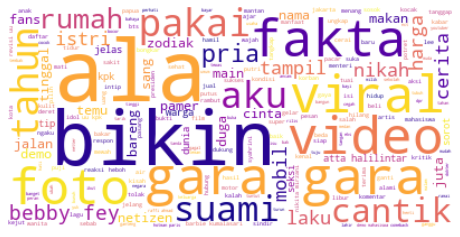

In [10]:
# Wordcloud for Clickbait Titles
clickbait_titles = ' '.join(full_df[full_df['label'] == 'clickbait']['title'])
clickbait_titles = preprocess_title(clickbait_titles)

clickbait_cloud = WordCloud(background_color='white',colormap='plasma').generate(clickbait_titles)
plt.imshow(clickbait_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

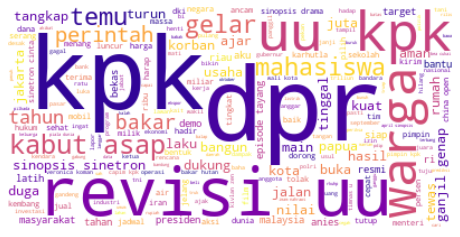

In [11]:
# WordcLoud for Non-Clickbait Titles
nonclickbait_titles = ' '.join(full_df[full_df['label'] == 'non-clickbait']['title'])
nonclickbait_titles = preprocess_title(nonclickbait_titles)

nonclickbait_cloud = WordCloud(background_color='white',colormap='plasma').generate(nonclickbait_titles)
plt.imshow(nonclickbait_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It can be seen how differ the words used in clickbait titles and non-clickbait titles. Non clickbait titles often put more emphasis on keywords that best represent the news such as: uu, revisi, dpr and kpk. On the contrary, clickbait titles uses more common word such as: video, gara gara, bikin, ala

### 4. Klasifikasi Judul Berita Clickbait

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split Data Train dan Test
y = full_df['label_score']
X_train, X_test, y_train, y_test = train_test_split(
    full_df['title'], y, test_size=0.3, random_state=27, stratify=y)

# Vectorize Text to TF-IDF
cv = TfidfVectorizer(preprocessor=preprocess_title)
tfidf_train = cv.fit_transform(X_train.values)
tfidf_test = cv.transform(X_test.values)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Random Forest
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt',
                            min_samples_split=10, random_state=42)
rf_base = rf.fit(tfidf_train,y_train)

# Naive Bayes
nb = MultinomialNB(alpha=1.25, fit_prior=False)
nb_base = nb.fit(tfidf_train,y_train)

# SVM
svm = SVC(C=1.5, coef0=2.75, probability=True, random_state=42)
svm_base = svm.fit(tfidf_train,y_train)

models = [rf_base, nb_base, svm_base]

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Model Accuracy Comparison
score = []
for model in models:
    for step in range(0,2):
        result = []
        x = str(model).find('(')
        model_name = str(model)[0:x]
        result.append(model_name)
        if step == 0:
            result.append('train_set')
            prediction = model.predict(tfidf_train)
            accuracy = round(accuracy_score(y_train,prediction)*100,2)
            f1 = round(f1_score(y_train,prediction)*100,2)
            precision = round(precision_score(y_train,prediction)*100,2)
            recall = round(recall_score(y_train,prediction)*100,2)
            result = result + [accuracy,precision,recall,f1]
        if step == 1:
            result.append('test_set')
            prediction = model.predict(tfidf_test)
            accuracy = round(accuracy_score(y_test,prediction)*100,2)
            f1 = round(f1_score(y_test,prediction)*100,2)
            precision = round(precision_score(y_test,prediction)*100,2)
            recall = round(recall_score(y_test,prediction)*100,2)
            result = result + [accuracy,precision,recall,f1]
        score.append(result)

# Sesuaikan Layout Tabel
score = pd.DataFrame(score,columns=['Model','Set_Data','accuracy','Presisi','Recall','F1'])
score = score.pivot_table(index='Model', columns='Set_Data').swaplevel(axis=1).sort_index(1)
score

Set_Data               test_set                         train_set          \
                             F1 Presisi Recall accuracy        F1 Presisi   
Model                                                                       
MultinomialNB             75.95   77.50  74.46    82.10     86.06   89.95   
RandomForestClassifier    72.04   79.77  65.67    80.64     98.27   98.31   
SVC                       75.92   83.50  69.60    83.24     99.40   99.96   

Set_Data                                
                       Recall accuracy  
Model                                   
MultinomialNB           82.50    89.85  
RandomForestClassifier  98.23    98.69  
SVC                     98.85    99.55

In [15]:
import joblib

# Result Directory
rdir = os.path.dirname(os.getcwd()) + '//classification models//'

# Save Models
vectorizer = joblib.dump(cv, open(rdir + 'cv.pkl', 'wb'))
svm_model = joblib.dump(svm_base, open(rdir + 'svm_model.pkl', 'wb'))
mnb_model = joblib.dump(nb_base, open(rdir + 'mnb_model.pkl', 'wb'))
rf_model = joblib.dump(rf_base, open(rdir + 'rf_model.pkl', 'wb'))